## Table of Contents
0. Initial Setup
1. Utility Functions
2. Network Loading and Preprocessing
   - 2.1 Load Networks
3. Community Detection Analysis
   - 3.1 Apply Infomap, Louvain and Greedy Algorithms
4. Comparison with Ground Truth
   - 4.1 Compute Jaccard Index, NMI, and NVI
   - 4.2 Plots
     - 4.2.1 Number of Detected Communities
     - 4.2.2 Modularity vs prr
     - 4.2.3 Jaccard Index vs prr
     - 4.2.4 Normalized Mutual Information (NMI) vs prr
     - 4.2.5 Variation of Information (NVI) vs prr
5. Network Visualization
   - 5.1 Color-coded Community Visualization for prr = 0.02, 0.16, 1.00
6. Discussion
   - 6.1 Limitations of Modularity
     - Q1: What are the limitations of modularity as a metric for evaluating community detection results?
     - Q2: Can we state that a network with Q = 0.4 has community structure?
   - 6.2 Observations on Differences between Algorithms
     - Q1: What is the difference between Louvain, Greedy and Infomap Algorithms?
     - Q2: Are the modularity values obtained equal? Why?



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from collections import Counter
from cdlib import evaluation
from cdlib.evaluation import normalized_mutual_information, variation_of_information, jaccard_index
import community as community_louvain
from tqdm import tqdm
from itertools import combinations
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

try:
    import infomap
except:
    !pip install infomap
    import infomap

try:
    import clusim
except:
    !pip install clusim

plt.style.use('ggplot')
%matplotlib inline

REPORT_FOLDER = "report"
PLOTS_FOLDER = "plots"

for folder in [REPORT_FOLDER, PLOTS_FOLDER]:
    if not os.path.exists(folder):
        os.makedirs(folder)


## 1. Utility Functions
Here we define helper functions used throughout the notebook.

In [2]:
def load_network(path):
    """
    Load a Pajek-format network and convert to simple undirected NetworkX graph.

    Parameters:
        path (str): Path to .net file.

    Returns:
        G (networkx.Graph): Cleaned graph with integer-labeled nodes.
    """
    G = nx.read_pajek(path)
    G = nx.Graph(G)
    G = nx.convert_node_labels_to_integers(G)
    return G

def detect_communities_infomap(G):
    """
    Apply Infomap algorithm to detect communities in G.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        communities (list[set]): Detected communities.
    """
    im = infomap.Infomap()
    mapping = im.add_networkx_graph(G)
    im.run()
    modules = im.get_modules()
    community_dict = defaultdict(set)
    for node, com in modules.items():
        community_dict[com].add(mapping[node])
    return list(community_dict.values())


def detect_communities_louvain(G):
    """
    Apply Louvain algorithm to detect communities in G using NetworkX interface.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        communities (list[set]): Detected communities.
    """
    return list(nx.community.louvain_communities(G))


def detect_communities_greedy(G):
    """
    Apply Greedy modularity algorithm to detect communities in G.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        communities (list[set]): Detected communities.
    """
    return list(greedy_modularity_communities(G))

def ground_truth_partition(N=300, block_size=60):
    """
    Generate the ground-truth partition from known SBM structure.

    Parameters:
        N (int): Total number of nodes.
        block_size (int): Size of each block.

    Returns:
        list[set]: Ground truth communities.
    """
    return [set(range(i * block_size, (i + 1) * block_size)) for i in range(N // block_size)]


## 2. Network Loading and Preprocessing

### 2.1 Load Networks
We load all synthetic networks from the folder `data/`, generated according to the Stochastic Block Model. Each network has 300 nodes and 5 blocks. The only parameter that changes is `prr`, ranging from 0.02 to 1.00.

Each filename has the form:
`synthetic_network_N_300_blocks_5_prr_{value}_prs_0.02.net`

In [3]:

from glob import glob
import re

networks = {}

for path in sorted(glob("data/*.net")):
    match = re.search(r"prr_([0-9.]+)_prs", path)
    if match:
        prr = float(match.group(1))
        networks[prr] = load_network(path)

networks = dict(sorted(networks.items()))  # Sort by prr




## 3. Community Detection Analysis
In this section, we apply the three required community detection algorithms to each network and store the partitions for further comparison.

In [4]:
infomap_partitions = {}
louvain_partitions = {}
greedy_partitions = {}

for prr, G in tqdm(networks.items(), desc="Applying Infomap"):
    infomap_partitions[prr] = detect_communities_infomap(G)
    louvain_partitions[prr] = detect_communities_louvain(G)
    greedy_partitions[prr] = detect_communities_greedy(G)

Applying Infomap:   2%|▏         | 1/50 [00:00<00:05,  9.57it/s]

  Infomap v2.8.0 starts at 2025-04-12 02:14:39
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 300 nodes and 917 links...
  -> One-level codelength: 8.12761271

Trial 1/1 starting at 2025-04-12 02:14:39
Two-level compression: 3.3% 1.2% 
Partitioned to codelength 2.39735547 + 5.37110513 = 7.768460593 in 23 (22 non-trivial) modules.
Super-level compression: to codelength 7.768460593 in 23 top modules.

Recursive sub-structure compression: 0% . Found 2 levels with codelength 7.768460593

=> Trial 1/1 finished in 0.007692907s with codelength 7.76846059


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [         23,           0] (sum: 23)
Per level number of leaf 

Applying Infomap:   6%|▌         | 3/50 [00:00<00:06,  7.33it/s]

. Found 2 levels with codelength 8.028817201

=> Trial 1/1 finished in 0.004084293s with codelength 8.0288172


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [         23,           0] (sum: 23)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [         23,     13.0435] (average: 13.7525)
Per level codelength for modules:    [2.576425425, 0.000000000] (sum: 2.576425425)
Per level codelength for leaf nodes: [0.000000000, 5.452391776] (sum: 5.452391776)
Per level codelength total:          [2.576425425, 5.452391776] (sum: 8.028817201)

  Infomap ends at 2025-04-12 02:14:39
  (Elapsed time: 0.004855394s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:39
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  10%|█         | 5/50 [00:00<00:07,  5.86it/s]


Partitioned to codelength 2.33473146 + 5.97350931 = 8.308240765 in 16 modules.
Worse codelength than one-level codelength, putting all nodes in one module... 
=> Trial 1/1 finished in 0.004216551s with codelength 8.16673078


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          1,           0] (sum: 1)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          1,         300] (average: 299.007)
Per level codelength for modules:    [0.000000000, 0.000000000] (sum: 0.000000000)
Per level codelength for leaf nodes: [0.000000000, 8.166730778] (sum: 8.166730778)
Per level codelength total:          [0.000000000, 8.166730778] (sum: 8.166730778)

  Infomap ends at 2025-04-12 02:14:39
  (Elapsed time: 0.005247307s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:40
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, 

Applying Infomap:  12%|█▏        | 6/50 [00:01<00:08,  5.13it/s]

. Found 2 levels with codelength 8.016850901

=> Trial 1/1 finished in 0.004789701s with codelength 8.0168509


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.942389595, 0.000000000] (sum: 0.942389595)
Per level codelength for leaf nodes: [0.000000000, 7.074461306] (sum: 7.074461306)
Per level codelength total:          [0.942389595, 7.074461306] (sum: 8.016850901)

  Infomap ends at 2025-04-12 02:14:40
  (Elapsed time: 0.005697318s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:40
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  14%|█▍        | 7/50 [00:01<00:08,  4.80it/s]

. Found 2 levels with codelength 7.872685619

=> Trial 1/1 finished in 0.006160353s with codelength 7.87268562


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.858252695, 0.000000000] (sum: 0.858252695)
Per level codelength for leaf nodes: [0.000000000, 7.014432924] (sum: 7.014432924)
Per level codelength total:          [0.858252695, 7.014432924] (sum: 7.872685619)

  Infomap ends at 2025-04-12 02:14:40
  (Elapsed time: 0.010267368s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:40
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  16%|█▌        | 8/50 [00:01<00:09,  4.52it/s]

. Found 2 levels with codelength 7.755051629

=> Trial 1/1 finished in 0.008549879s with codelength 7.75505163


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.791747752, 0.000000000] (sum: 0.791747752)
Per level codelength for leaf nodes: [0.000000000, 6.963303877] (sum: 6.963303877)
Per level codelength total:          [0.791747752, 6.963303877] (sum: 7.755051629)

  Infomap ends at 2025-04-12 02:14:40
  (Elapsed time: 0.014110872s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:40
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  18%|█▊        | 9/50 [00:01<00:09,  4.35it/s]

. Found 2 levels with codelength 7.651036586

=> Trial 1/1 finished in 0.004502595s with codelength 7.65103659


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.735438106, 0.000000000] (sum: 0.735438106)
Per level codelength for leaf nodes: [0.000000000, 6.915598480] (sum: 6.915598480)
Per level codelength total:          [0.735438106, 6.915598480] (sum: 7.651036586)

  Infomap ends at 2025-04-12 02:14:40
  (Elapsed time: 0.00588047s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:41
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  20%|██        | 10/50 [00:01<00:09,  4.29it/s]

. Found 2 levels with codelength 7.564847936

=> Trial 1/1 finished in 0.004169712s with codelength 7.56484794


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.687436102, 0.000000000] (sum: 0.687436102)
Per level codelength for leaf nodes: [0.000000000, 6.877411834] (sum: 6.877411834)
Per level codelength total:          [0.687436102, 6.877411834] (sum: 7.564847936)

  Infomap ends at 2025-04-12 02:14:41
  (Elapsed time: 0.005160835s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:41
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  22%|██▏       | 11/50 [00:02<00:09,  4.21it/s]

. Found 2 levels with codelength 7.469014455

=> Trial 1/1 finished in 0.004301318s with codelength 7.46901446


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.636173156, 0.000000000] (sum: 0.636173156)
Per level codelength for leaf nodes: [0.000000000, 6.832841299] (sum: 6.832841299)
Per level codelength total:          [0.636173156, 6.832841299] (sum: 7.469014455)

  Infomap ends at 2025-04-12 02:14:41
  (Elapsed time: 0.006003188s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:41
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  24%|██▍       | 12/50 [00:02<00:09,  4.14it/s]

. Found 2 levels with codelength 7.398158524

=> Trial 1/1 finished in 0.00407753s with codelength 7.39815852


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.599513846, 0.000000000] (sum: 0.599513846)
Per level codelength for leaf nodes: [0.000000000, 6.798644679] (sum: 6.798644679)
Per level codelength total:          [0.599513846, 6.798644679] (sum: 7.398158524)

  Infomap ends at 2025-04-12 02:14:41
  (Elapsed time: 0.006021403s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:41
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  26%|██▌       | 13/50 [00:02<00:09,  4.01it/s]

. Found 2 levels with codelength 7.32710719

=> Trial 1/1 finished in 0.004554522s with codelength 7.32710719


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.562736281, 0.000000000] (sum: 0.562736281)
Per level codelength for leaf nodes: [0.000000000, 6.764370909] (sum: 6.764370909)
Per level codelength total:          [0.562736281, 6.764370909] (sum: 7.327107190)

  Infomap ends at 2025-04-12 02:14:41
  (Elapsed time: 0.009008304s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:42
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  28%|██▊       | 14/50 [00:03<00:09,  3.93it/s]

. Found 2 levels with codelength 7.263968699

=> Trial 1/1 finished in 0.007068378s with codelength 7.2639687


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.530704947, 0.000000000] (sum: 0.530704947)
Per level codelength for leaf nodes: [0.000000000, 6.733263752] (sum: 6.733263752)
Per level codelength total:          [0.530704947, 6.733263752] (sum: 7.263968699)

  Infomap ends at 2025-04-12 02:14:42
  (Elapsed time: 0.011896861s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:42
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  30%|███       | 15/50 [00:03<00:10,  3.49it/s]

. Found 2 levels with codelength 7.205705233

=> Trial 1/1 finished in 0.00361754s with codelength 7.20570523


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.501975994, 0.000000000] (sum: 0.501975994)
Per level codelength for leaf nodes: [0.000000000, 6.703729239] (sum: 6.703729239)
Per level codelength total:          [0.501975994, 6.703729239] (sum: 7.205705233)

  Infomap ends at 2025-04-12 02:14:42
  (Elapsed time: 0.006163026s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:42
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  32%|███▏      | 16/50 [00:03<00:09,  3.54it/s]

. Found 2 levels with codelength 7.158527851

=> Trial 1/1 finished in 0.003830418s with codelength 7.15852785


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.479005167, 0.000000000] (sum: 0.479005167)
Per level codelength for leaf nodes: [0.000000000, 6.679522684] (sum: 6.679522684)
Per level codelength total:          [0.479005167, 6.679522684] (sum: 7.158527851)

  Infomap ends at 2025-04-12 02:14:42
  (Elapsed time: 0.009062545s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:43
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  34%|███▍      | 17/50 [00:03<00:09,  3.57it/s]

. Found 2 levels with codelength 7.106453674

=> Trial 1/1 finished in 0.003441831s with codelength 7.10645367


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.453298726, 0.000000000] (sum: 0.453298726)
Per level codelength for leaf nodes: [0.000000000, 6.653154948] (sum: 6.653154948)
Per level codelength total:          [0.453298726, 6.653154948] (sum: 7.106453674)

  Infomap ends at 2025-04-12 02:14:43
  (Elapsed time: 0.005433533s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:43
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  36%|███▌      | 18/50 [00:04<00:08,  3.56it/s]

. Found 2 levels with codelength 7.066034205

=> Trial 1/1 finished in 0.003199078s with codelength 7.06603421


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.433600103, 0.000000000] (sum: 0.433600103)
Per level codelength for leaf nodes: [0.000000000, 6.632434103] (sum: 6.632434103)
Per level codelength total:          [0.433600103, 6.632434103] (sum: 7.066034205)

  Infomap ends at 2025-04-12 02:14:43
  (Elapsed time: 0.00449527s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:43
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  38%|███▊      | 19/50 [00:04<00:08,  3.52it/s]

. Found 2 levels with codelength 7.028526277

=> Trial 1/1 finished in 0.003642797s with codelength 7.02852628


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.415542232, 0.000000000] (sum: 0.415542232)
Per level codelength for leaf nodes: [0.000000000, 6.612984044] (sum: 6.612984044)
Per level codelength total:          [0.415542232, 6.612984044] (sum: 7.028526277)

  Infomap ends at 2025-04-12 02:14:43
  (Elapsed time: 0.004946753s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:43
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  40%|████      | 20/50 [00:04<00:08,  3.48it/s]

. Found 2 levels with codelength 6.992343231

=> Trial 1/1 finished in 0.003331104s with codelength 6.99234323


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.398090622, 0.000000000] (sum: 0.398090622)
Per level codelength for leaf nodes: [0.000000000, 6.594252609] (sum: 6.594252609)
Per level codelength total:          [0.398090622, 6.594252609] (sum: 6.992343231)

  Infomap ends at 2025-04-12 02:14:43
  (Elapsed time: 0.004694321s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:44
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  42%|████▏     | 21/50 [00:05<00:08,  3.48it/s]

. Found 2 levels with codelength 6.958080538

=> Trial 1/1 finished in 0.003129698s with codelength 6.95808054


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.381874755, 0.000000000] (sum: 0.381874755)
Per level codelength for leaf nodes: [0.000000000, 6.576205783] (sum: 6.576205783)
Per level codelength total:          [0.381874755, 6.576205783] (sum: 6.958080538)

  Infomap ends at 2025-04-12 02:14:44
  (Elapsed time: 0.005781763s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:44
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  44%|████▍     | 22/50 [00:05<00:08,  3.47it/s]

. Found 2 levels with codelength 6.925202178

=> Trial 1/1 finished in 0.003156178s with codelength 6.92520218


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.366691684, 0.000000000] (sum: 0.366691684)
Per level codelength for leaf nodes: [0.000000000, 6.558510494] (sum: 6.558510494)
Per level codelength total:          [0.366691684, 6.558510494] (sum: 6.925202178)

  Infomap ends at 2025-04-12 02:14:44
  (Elapsed time: 0.008863702s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:44
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  46%|████▌     | 23/50 [00:05<00:08,  3.12it/s]

. Found 2 levels with codelength 6.896534185

=> Trial 1/1 finished in 0.003673534s with codelength 6.89653418


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.353400250, 0.000000000] (sum: 0.353400250)
Per level codelength for leaf nodes: [0.000000000, 6.543133935] (sum: 6.543133935)
Per level codelength total:          [0.353400250, 6.543133935] (sum: 6.896534185)

  Infomap ends at 2025-04-12 02:14:44
  (Elapsed time: 0.006699819s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:45
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  48%|████▊     | 24/50 [00:06<00:08,  3.15it/s]

. Found 2 levels with codelength 6.86609827

=> Trial 1/1 finished in 0.003359176s with codelength 6.86609827


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.339545553, 0.000000000] (sum: 0.339545553)
Per level codelength for leaf nodes: [0.000000000, 6.526552717] (sum: 6.526552717)
Per level codelength total:          [0.339545553, 6.526552717] (sum: 6.866098270)

  Infomap ends at 2025-04-12 02:14:45
  (Elapsed time: 0.00583951s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:45
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'..

Applying Infomap:  50%|█████     | 25/50 [00:06<00:07,  3.13it/s]

. Found 2 levels with codelength 6.841097247

=> Trial 1/1 finished in 0.005514463s with codelength 6.84109725


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.328181651, 0.000000000] (sum: 0.328181651)
Per level codelength for leaf nodes: [0.000000000, 6.512915596] (sum: 6.512915596)
Per level codelength total:          [0.328181651, 6.512915596] (sum: 6.841097247)

  Infomap ends at 2025-04-12 02:14:45
  (Elapsed time: 0.01110056s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:45
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  52%|█████▏    | 26/50 [00:06<00:07,  3.18it/s]

. Found 2 levels with codelength 6.816159874

=> Trial 1/1 finished in 0.003326595s with codelength 6.81615987


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.317199555, 0.000000000] (sum: 0.317199555)
Per level codelength for leaf nodes: [0.000000000, 6.498960319] (sum: 6.498960319)
Per level codelength total:          [0.317199555, 6.498960319] (sum: 6.816159874)

  Infomap ends at 2025-04-12 02:14:45
  (Elapsed time: 0.007352668s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:46
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  54%|█████▍    | 27/50 [00:07<00:07,  3.19it/s]

. Found 2 levels with codelength 6.792117386

=> Trial 1/1 finished in 0.005230963s with codelength 6.79211739


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.306542653, 0.000000000] (sum: 0.306542653)
Per level codelength for leaf nodes: [0.000000000, 6.485574734] (sum: 6.485574734)
Per level codelength total:          [0.306542653, 6.485574734] (sum: 6.792117386)

  Infomap ends at 2025-04-12 02:14:46
  (Elapsed time: 0.010130707s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:46
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  56%|█████▌    | 28/50 [00:07<00:06,  3.18it/s]

. Found 2 levels with codelength 6.771916809

=> Trial 1/1 finished in 0.006986803s with codelength 6.77191681


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.297769006, 0.000000000] (sum: 0.297769006)
Per level codelength for leaf nodes: [0.000000000, 6.474147803] (sum: 6.474147803)
Per level codelength total:          [0.297769006, 6.474147803] (sum: 6.771916809)

  Infomap ends at 2025-04-12 02:14:46
  (Elapsed time: 0.012285212s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:46
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  58%|█████▊    | 29/50 [00:07<00:07,  2.93it/s]

. Found 2 levels with codelength 6.752026332

=> Trial 1/1 finished in 0.004538378s with codelength 6.75202633


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.289287285, 0.000000000] (sum: 0.289287285)
Per level codelength for leaf nodes: [0.000000000, 6.462739048] (sum: 6.462739048)
Per level codelength total:          [0.289287285, 6.462739048] (sum: 6.752026332)

  Infomap ends at 2025-04-12 02:14:46
  (Elapsed time: 0.010103336s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:47
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  60%|██████    | 30/50 [00:08<00:06,  2.97it/s]

. Found 2 levels with codelength 6.732762388

=> Trial 1/1 finished in 0.003707005s with codelength 6.73276239


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.280766234, 0.000000000] (sum: 0.280766234)
Per level codelength for leaf nodes: [0.000000000, 6.451996154] (sum: 6.451996154)
Per level codelength total:          [0.280766234, 6.451996154] (sum: 6.732762388)

  Infomap ends at 2025-04-12 02:14:47
  (Elapsed time: 0.00629445s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:47
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  62%|██████▏   | 31/50 [00:08<00:06,  2.97it/s]

. Found 2 levels with codelength 6.71529143

=> Trial 1/1 finished in 0.003671289s with codelength 6.71529143


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.273344506, 0.000000000] (sum: 0.273344506)
Per level codelength for leaf nodes: [0.000000000, 6.441946925] (sum: 6.441946925)
Per level codelength total:          [0.273344506, 6.441946925] (sum: 6.715291430)

  Infomap ends at 2025-04-12 02:14:47
  (Elapsed time: 0.005851722s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:47
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  64%|██████▍   | 32/50 [00:08<00:06,  2.95it/s]

. Found 2 levels with codelength 6.696752355

=> Trial 1/1 finished in 0.003574087s with codelength 6.69675235


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.265393748, 0.000000000] (sum: 0.265393748)
Per level codelength for leaf nodes: [0.000000000, 6.431358607] (sum: 6.431358607)
Per level codelength total:          [0.265393748, 6.431358607] (sum: 6.696752355)

  Infomap ends at 2025-04-12 02:14:47
  (Elapsed time: 0.005535952s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:48
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  66%|██████▌   | 33/50 [00:09<00:06,  2.75it/s]

. Found 2 levels with codelength 6.680864818

=> Trial 1/1 finished in 0.003779049s with codelength 6.68086482


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.258556812, 0.000000000] (sum: 0.258556812)
Per level codelength for leaf nodes: [0.000000000, 6.422308005] (sum: 6.422308005)
Per level codelength total:          [0.258556812, 6.422308005] (sum: 6.680864818)

  Infomap ends at 2025-04-12 02:14:48
  (Elapsed time: 0.006151151s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:48
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  68%|██████▊   | 34/50 [00:09<00:05,  2.78it/s]

. Found 2 levels with codelength 6.664805097

=> Trial 1/1 finished in 0.006403011s with codelength 6.6648051


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.251765738, 0.000000000] (sum: 0.251765738)
Per level codelength for leaf nodes: [0.000000000, 6.413039360] (sum: 6.413039360)
Per level codelength total:          [0.251765738, 6.413039360] (sum: 6.664805097)

  Infomap ends at 2025-04-12 02:14:48
  (Elapsed time: 0.011936098s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:48
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  70%|███████   | 35/50 [00:09<00:05,  2.83it/s]

. Found 2 levels with codelength 6.651053985

=> Trial 1/1 finished in 0.00655226s with codelength 6.65105398


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.245923379, 0.000000000] (sum: 0.245923379)
Per level codelength for leaf nodes: [0.000000000, 6.405130605] (sum: 6.405130605)
Per level codelength total:          [0.245923379, 6.405130605] (sum: 6.651053985)

  Infomap ends at 2025-04-12 02:14:48
  (Elapsed time: 0.01062063s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:49
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'..

Applying Infomap:  72%|███████▏  | 36/50 [00:10<00:04,  2.89it/s]

. Found 2 levels with codelength 6.636078659

=> Trial 1/1 finished in 0.003750435s with codelength 6.63607866


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.239704468, 0.000000000] (sum: 0.239704468)
Per level codelength for leaf nodes: [0.000000000, 6.396374191] (sum: 6.396374191)
Per level codelength total:          [0.239704468, 6.396374191] (sum: 6.636078659)

  Infomap ends at 2025-04-12 02:14:49
  (Elapsed time: 0.00566388s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:49
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  74%|███████▍  | 37/50 [00:10<00:04,  2.94it/s]

. Found 2 levels with codelength 6.622093075

=> Trial 1/1 finished in 0.003762929s with codelength 6.62209308


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.233920538, 0.000000000] (sum: 0.233920538)
Per level codelength for leaf nodes: [0.000000000, 6.388172537] (sum: 6.388172537)
Per level codelength total:          [0.233920538, 6.388172537] (sum: 6.622093075)

  Infomap ends at 2025-04-12 02:14:49
  (Elapsed time: 0.005858664s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:49
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  76%|███████▌  | 38/50 [00:10<00:04,  2.73it/s]

. Found 2 levels with codelength 6.608564412

=> Trial 1/1 finished in 0.003821268s with codelength 6.60856441


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.228256375, 0.000000000] (sum: 0.228256375)
Per level codelength for leaf nodes: [0.000000000, 6.380308037] (sum: 6.380308037)
Per level codelength total:          [0.228256375, 6.380308037] (sum: 6.608564412)

  Infomap ends at 2025-04-12 02:14:49
  (Elapsed time: 0.009013156s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:50
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  78%|███████▊  | 39/50 [00:11<00:03,  2.78it/s]

. Found 2 levels with codelength 6.596220928

=> Trial 1/1 finished in 0.007327987s with codelength 6.59622093


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.223180694, 0.000000000] (sum: 0.223180694)
Per level codelength for leaf nodes: [0.000000000, 6.373040234] (sum: 6.373040234)
Per level codelength total:          [0.223180694, 6.373040234] (sum: 6.596220928)

  Infomap ends at 2025-04-12 02:14:50
  (Elapsed time: 0.011378684s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:50
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  80%|████████  | 40/50 [00:11<00:03,  2.83it/s]

. Found 2 levels with codelength 6.584118994

=> Trial 1/1 finished in 0.004318487s with codelength 6.58411899


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.218325836, 0.000000000] (sum: 0.218325836)
Per level codelength for leaf nodes: [0.000000000, 6.365793158] (sum: 6.365793158)
Per level codelength total:          [0.218325836, 6.365793158] (sum: 6.584118994)

  Infomap ends at 2025-04-12 02:14:50
  (Elapsed time: 0.010113321s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:51
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  82%|████████▏ | 41/50 [00:11<00:03,  2.85it/s]

. Found 2 levels with codelength 6.571660353

=> Trial 1/1 finished in 0.006508777s with codelength 6.57166035


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.213250394, 0.000000000] (sum: 0.213250394)
Per level codelength for leaf nodes: [0.000000000, 6.358409959] (sum: 6.358409959)
Per level codelength total:          [0.213250394, 6.358409959] (sum: 6.571660353)

  Infomap ends at 2025-04-12 02:14:51
  (Elapsed time: 0.010597193s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:51
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  84%|████████▍ | 42/50 [00:12<00:03,  2.66it/s]

. Found 2 levels with codelength 6.56008576

=> Trial 1/1 finished in 0.005966494s with codelength 6.56008576


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.208558416, 0.000000000] (sum: 0.208558416)
Per level codelength for leaf nodes: [0.000000000, 6.351527344] (sum: 6.351527344)
Per level codelength total:          [0.208558416, 6.351527344] (sum: 6.560085760)

  Infomap ends at 2025-04-12 02:14:51
  (Elapsed time: 0.011632407s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:51
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  86%|████████▌ | 43/50 [00:12<00:02,  2.69it/s]

. Found 2 levels with codelength 6.55029471

=> Trial 1/1 finished in 0.004028825s with codelength 6.55029471


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.204655920, 0.000000000] (sum: 0.204655920)
Per level codelength for leaf nodes: [0.000000000, 6.345638790] (sum: 6.345638790)
Per level codelength total:          [0.204655920, 6.345638790] (sum: 6.550294710)

  Infomap ends at 2025-04-12 02:14:51
  (Elapsed time: 0.006385327s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:52
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'.

Applying Infomap:  88%|████████▊ | 44/50 [00:13<00:02,  2.71it/s]

. Found 2 levels with codelength 6.539883353

=> Trial 1/1 finished in 0.007630511s with codelength 6.53988335


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.200448356, 0.000000000] (sum: 0.200448356)
Per level codelength for leaf nodes: [0.000000000, 6.339434997] (sum: 6.339434997)
Per level codelength total:          [0.200448356, 6.339434997] (sum: 6.539883353)

  Infomap ends at 2025-04-12 02:14:52
  (Elapsed time: 0.010061702s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:52
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  90%|█████████ | 45/50 [00:13<00:01,  2.52it/s]

. Found 2 levels with codelength 6.529404533

=> Trial 1/1 finished in 0.007306537s with codelength 6.52940453


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.196229604, 0.000000000] (sum: 0.196229604)
Per level codelength for leaf nodes: [0.000000000, 6.333174930] (sum: 6.333174930)
Per level codelength total:          [0.196229604, 6.333174930] (sum: 6.529404533)

  Infomap ends at 2025-04-12 02:14:52
  (Elapsed time: 0.009669619s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:53
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  92%|█████████▏| 46/50 [00:13<00:01,  2.62it/s]

. Found 2 levels with codelength 6.519132789

=> Trial 1/1 finished in 0.005701418s with codelength 6.51913279


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.192184772, 0.000000000] (sum: 0.192184772)
Per level codelength for leaf nodes: [0.000000000, 6.326948017] (sum: 6.326948017)
Per level codelength total:          [0.192184772, 6.326948017] (sum: 6.519132789)

  Infomap ends at 2025-04-12 02:14:53
  (Elapsed time: 0.008880766s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:53
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  94%|█████████▍| 47/50 [00:14<00:01,  2.67it/s]

. Found 2 levels with codelength 6.510431341

=> Trial 1/1 finished in 0.006823484s with codelength 6.51043134


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.188740753, 0.000000000] (sum: 0.188740753)
Per level codelength for leaf nodes: [0.000000000, 6.321690588] (sum: 6.321690588)
Per level codelength total:          [0.188740753, 6.321690588] (sum: 6.510431341)

  Infomap ends at 2025-04-12 02:14:53
  (Elapsed time: 0.010309974s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:53
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  96%|█████████▌| 48/50 [00:14<00:00,  2.69it/s]

. Found 2 levels with codelength 6.501445918

=> Trial 1/1 finished in 0.004284402s with codelength 6.50144592


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.185216718, 0.000000000] (sum: 0.185216718)
Per level codelength for leaf nodes: [0.000000000, 6.316229200] (sum: 6.316229200)
Per level codelength total:          [0.185216718, 6.316229200] (sum: 6.501445918)

  Infomap ends at 2025-04-12 02:14:53
  (Elapsed time: 0.009602804s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:54
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap:  98%|█████████▊| 49/50 [00:15<00:00,  2.49it/s]

. Found 2 levels with codelength 6.492159075

=> Trial 1/1 finished in 0.006117725s with codelength 6.49215907


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.181589656, 0.000000000] (sum: 0.181589656)
Per level codelength for leaf nodes: [0.000000000, 6.310569419] (sum: 6.310569419)
Per level codelength total:          [0.181589656, 6.310569419] (sum: 6.492159075)

  Infomap ends at 2025-04-12 02:14:54
  (Elapsed time: 0.012299019s)
  Infomap v2.8.0 starts at 2025-04-12 02:14:54
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 12 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'

Applying Infomap: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


## 4. Comparison with Ground Truth

### 4.1 Compute Jaccard Index, NMI, and NVI
Here, we compare the community partitions obtained with each algorithm to the ground truth using standard metrics: Jaccard Index, Normalized Mutual Information (NMI), and Normalized Variation of Information (NVI).

In [5]:
from cdlib import NodeClustering

results = []

gt = ground_truth_partition()

for prr in networks:
    for algo_name, partitions in zip(
        ["Infomap", "Louvain", "Greedy"],
        [infomap_partitions, louvain_partitions, greedy_partitions]
    ):
        part = partitions[prr]

        gt_nc = NodeClustering(communities=gt, graph=None)
        part_nc = NodeClustering(communities=part, graph=None)

        jacc = jaccard_index(gt_nc, part_nc).score
        nmi = normalized_mutual_information(gt_nc, part_nc).score
        nvi = variation_of_information(gt_nc, part_nc).score

        results.append({
            "prr": prr,
            "algorithm": algo_name,
            "Jaccard": jacc,
            "NMI": nmi,
            "NVI": nvi
        })

# Convert to DataFrame
df_scores = pd.DataFrame(results)
df_scores.to_csv(os.path.join(REPORT_FOLDER, "metrics_scores.csv"), index=False)
df_scores


,prr,algorithm,Jaccard,NMI,NVI
0,0.02,Infomap,0.045022,0.086660,6.045278
1,0.02,Louvain,0.069881,0.031379,5.453455
2,0.02,Greedy,0.074922,0.033396,5.413072
3,0.04,Infomap,0.050629,0.093814,5.971273
4,0.04,Louvain,0.070316,0.069779,5.469418
...,...,...,...,...,...
145,0.98,Louvain,1.000000,1.000000,0.000000
146,0.98,Greedy,1.000000,1.000000,0.000000
147,1.00,Infomap,1.000000,1.000000,0.000000
148,1.00,Louvain,1.000000,1.000000,0.000000


### 4.2 Plots
We analyze how the number of detected communities and modularity change as a function of `prr`.

#### 4.2.1 Number of Detected Communities
We count the number of communities detected by each algorithm for every value of `prr`, and plot the evolution to understand how the resolution of the detected structure changes.

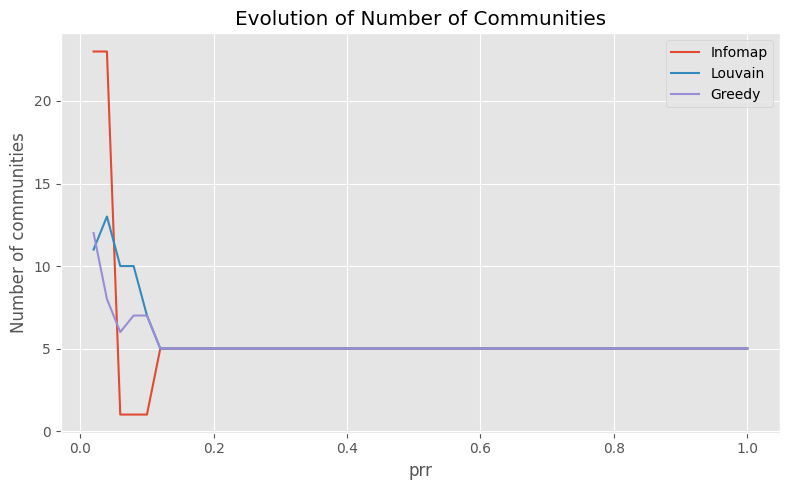

In [6]:

num_communities = []

for prr in networks:
    for algo_name, partitions in zip(
        ["Infomap", "Louvain", "Greedy"],
        [infomap_partitions, louvain_partitions, greedy_partitions]
    ):
        part = partitions[prr]
        num_communities.append({
            "prr": prr,
            "algorithm": algo_name,
            "num_communities": len(part)
        })

num_df = pd.DataFrame(num_communities)
num_df.to_csv(os.path.join(REPORT_FOLDER, "communities_count.csv"), index=False)

plt.figure(figsize=(8, 5))
for algo in num_df['algorithm'].unique():
    subset = num_df[num_df['algorithm'] == algo]
    plt.plot(subset['prr'], subset['num_communities'], label=algo)

plt.xlabel("prr")
plt.ylabel("Number of communities")
plt.title("Evolution of Number of Communities")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, "num_communities_vs_prr.png"))
plt.show()


#### 4.2.2 Modularity vs prr
We compute the modularity of each partition for each algorithm and plot its evolution as `prr` increases, to evaluate the strength of the detected community structure.

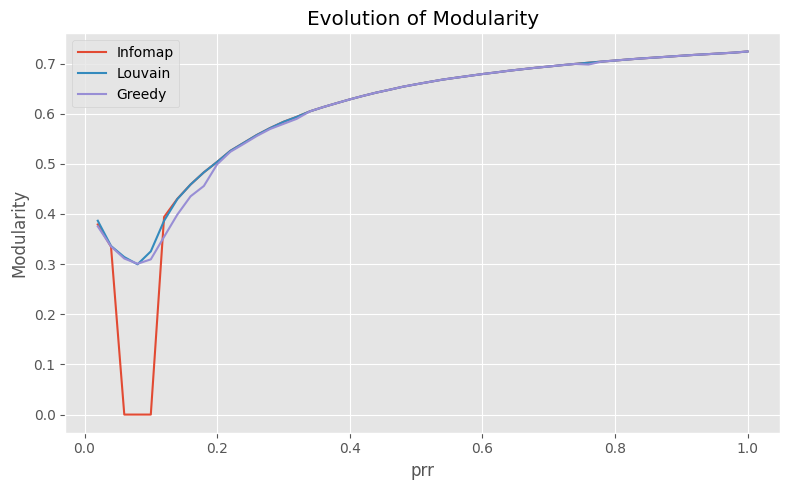

In [7]:

modularity_data = []

for prr, G in networks.items():
    for algo_name, partitions in zip(
        ["Infomap", "Louvain", "Greedy"],
        [infomap_partitions, louvain_partitions, greedy_partitions]
    ):
        part = partitions[prr]
        mod = modularity(G, part)
        modularity_data.append({
            "prr": prr,
            "algorithm": algo_name,
            "modularity": mod
        })

mod_df = pd.DataFrame(modularity_data)
mod_df.to_csv(os.path.join(REPORT_FOLDER, "modularity_scores.csv"), index=False)

plt.figure(figsize=(8, 5))
for algo in mod_df['algorithm'].unique():
    subset = mod_df[mod_df['algorithm'] == algo]
    plt.plot(subset['prr'], subset['modularity'], label=algo)

plt.xlabel("prr")
plt.ylabel("Modularity")
plt.title("Evolution of Modularity")
plt.savefig(os.path.join(PLOTS_FOLDER, "modularity_vs_prr.png"))
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, "num_communities_vs_prr.png"))
plt.show()



##### 4.2.3 Jaccard Index vs prr
This plot shows how the Jaccard index evolves as `prr` increases. Since `prr` represents the probability of intra-community connections, increasing it should reinforce the community structure. Therefore, we expect the Jaccard index, which measures similarity to the ground truth, to increase as `prr` increases.

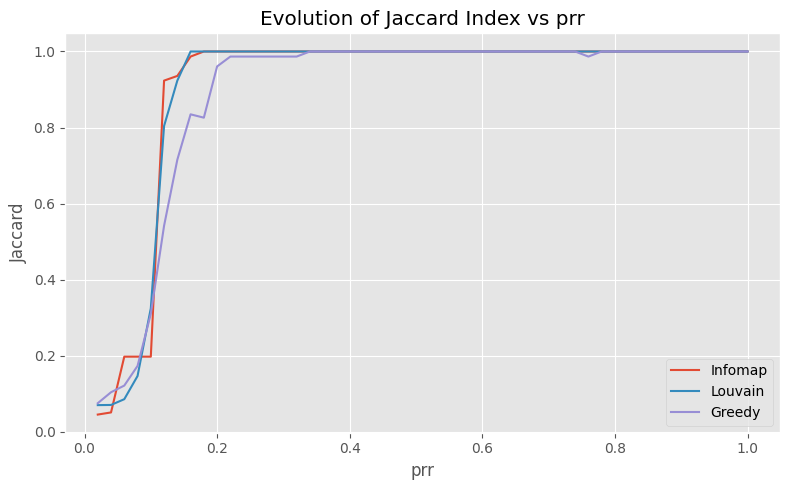

In [8]:
plt.figure(figsize=(8, 5))
for algo in df_scores["algorithm"].unique():
    subset = df_scores[df_scores["algorithm"] == algo]
    plt.plot(subset["prr"], subset["Jaccard"], label=algo)
plt.xlabel("prr")
plt.ylabel("Jaccard")
plt.title("Evolution of Jaccard Index vs prr")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, "jaccard_vs_prr.png"))
plt.show()

#### 4.2.4 Normalized Mutual Information (NMI) vs prr
This plot shows the behavior of NMI, a similarity-based index. Just like Jaccard, we expect NMI to increase with `prr`, as community structure becomes more clearly defined.

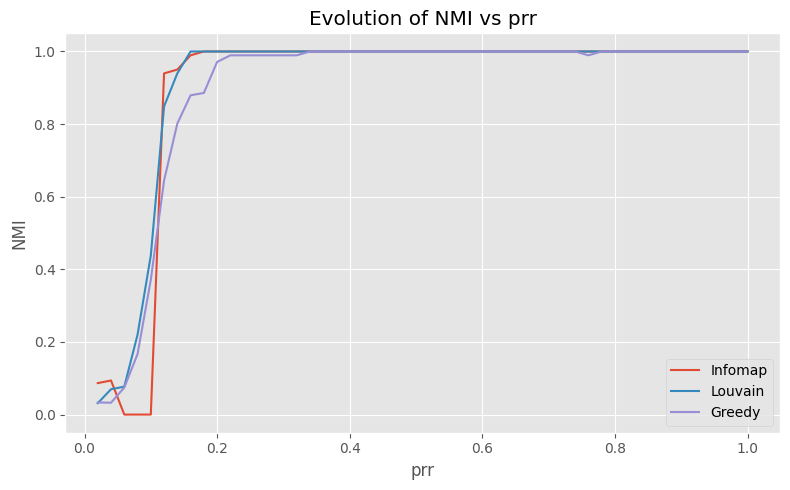

In [9]:
plt.figure(figsize=(8, 5))
for algo in df_scores["algorithm"].unique():
    subset = df_scores[df_scores["algorithm"] == algo]
    plt.plot(subset["prr"], subset["NMI"], label=algo)
plt.xlabel("prr")
plt.ylabel("NMI")
plt.title("Evolution of NMI vs prr")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, "nmi_vs_prr.png"))
plt.show()

#### 4.2.5 Variation of Information (NVI) vs prr
NVI is a distance metric: the higher it is, the more different the detected partition is from the ground truth. Since increasing `prr` reinforces community structure, the detected partitions should be closer to the ground truth. Thus, we expect NVI to decrease with `prr`.

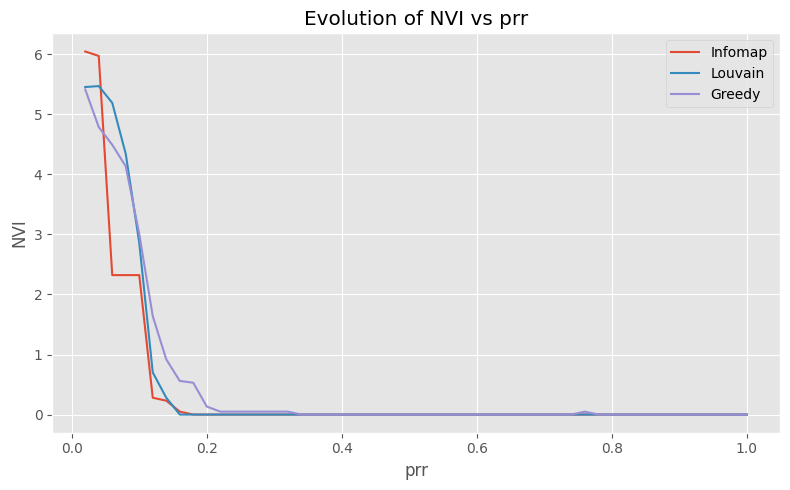

In [10]:
plt.figure(figsize=(8, 5))
for algo in df_scores["algorithm"].unique():
    subset = df_scores[df_scores["algorithm"] == algo]
    plt.plot(subset["prr"], subset["NVI"], label=algo)
plt.xlabel("prr")
plt.ylabel("NVI")
plt.title("Evolution of NVI vs prr")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, "nvi_vs_prr.png"))
plt.show()

## 5. Network Visualization

### 5.1 Color-coded Community Visualization for prr = 0.02, 0.16, 1.00
We visualize the community structure detected by each algorithm at three different values of `prr`.

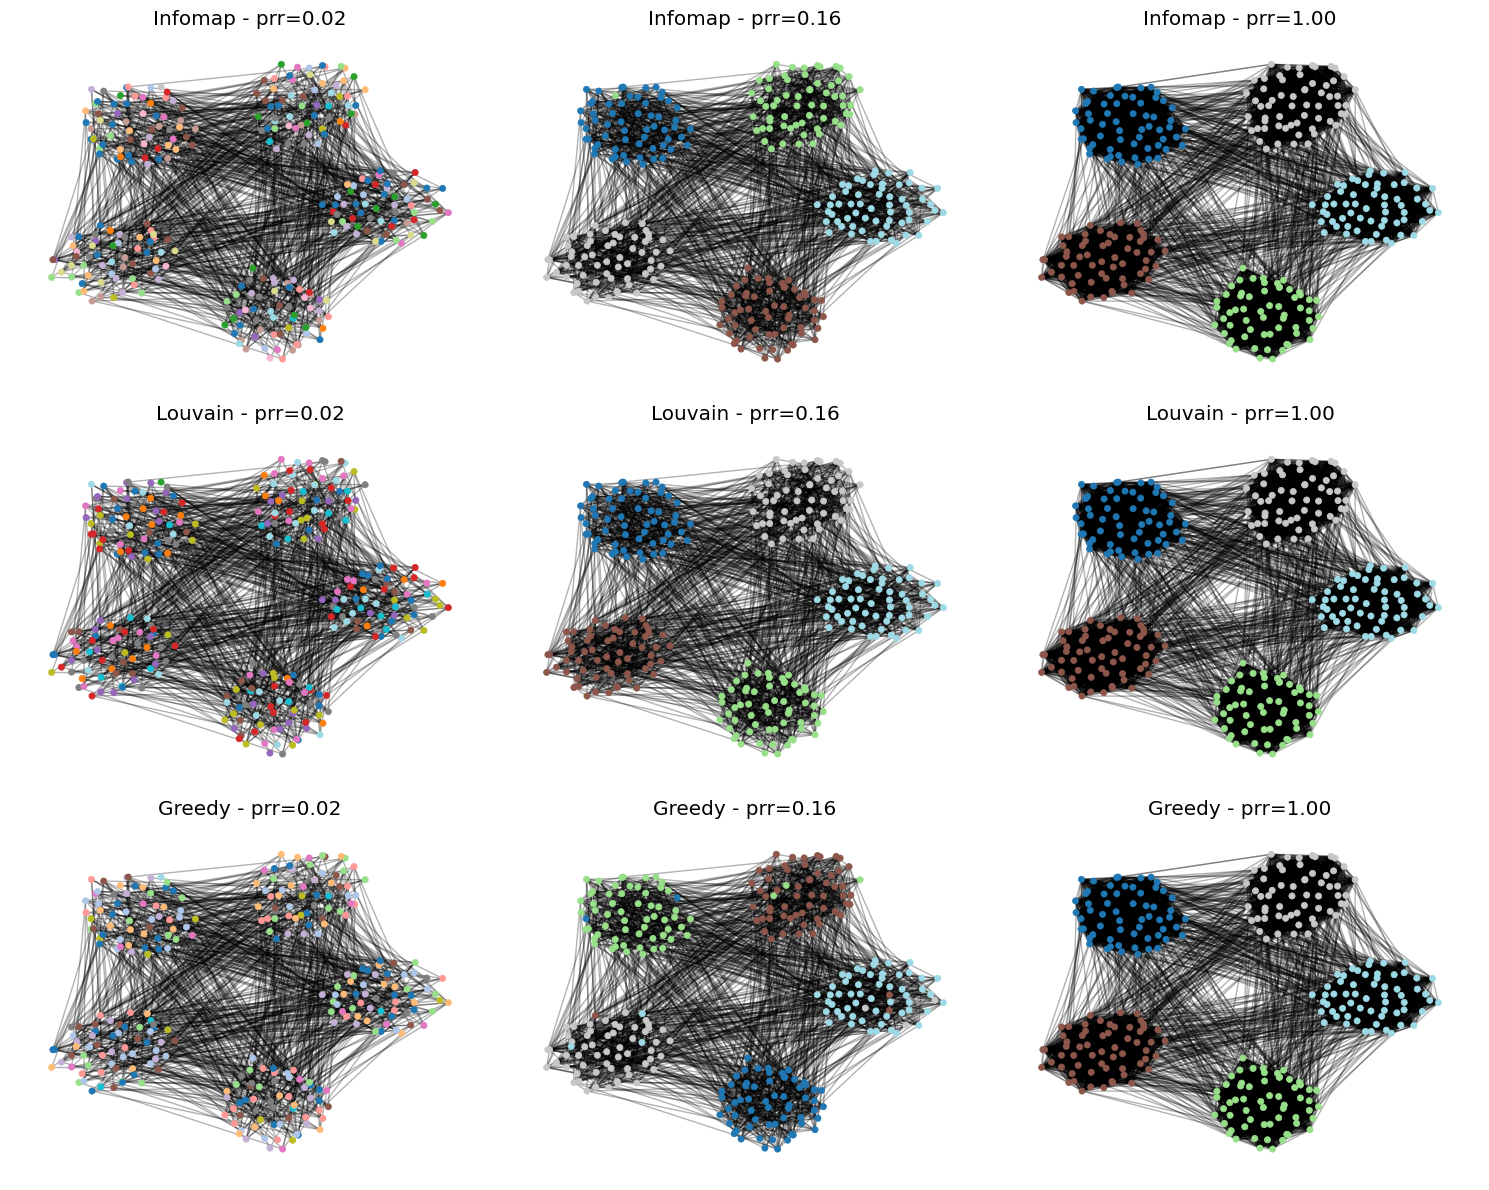

In [11]:

reference_G = networks[1.00]
positions = nx.spring_layout(reference_G, seed=42)

# Function to get color mapping from partition
def community_colors(partition, G):
    color_map = {}
    for i, community in enumerate(partition):
        for node in community:
            color_map[node] = i
    return [color_map[node] for node in G.nodes()]

# Grid Plotting per algorithm
selected_prr = [0.02, 0.16, 1.00]
algorithms = [
    ("Infomap", infomap_partitions),
    ("Louvain", louvain_partitions),
    ("Greedy", greedy_partitions)
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i, (algo_name, partition_dict) in enumerate(algorithms):
    for j, prr in enumerate(selected_prr):
        G = networks[prr]
        partition = partition_dict[prr]
        color_list = community_colors(partition, G)

        ax = axes[i, j]
        nx.draw_networkx_nodes(G, pos=positions, node_color=color_list,
                               cmap=plt.cm.tab20, node_size=20, ax=ax)
        nx.draw_networkx_edges(G, pos=positions, alpha=0.3, ax=ax)
        ax.set_title(f"{algo_name} - prr={prr:.2f}")
        ax.set_axis_off()

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, "community_grid_visualization.png"))
plt.show()





## 6. Discussion

### 6.1 Limitations of Modularity
Below we address some conceptual questions to guide the discussion on modularity as an indicator of community structure.

**Q1: What are the limitations of modularity as a metric for evaluating community detection results?**

Modularity-based algorithms (Louvain, Greedy) suffer from the **resolution limit**: in large networks, small but well-formed communities may be merged into larger ones if doing so increases the overall modularity. As a result, meaningful small-scale structures can be missed.

Additionally, modularity may be **misleading in random networks**: even networks generated without any community structure (Erdős-Rényi) can exhibit relatively high modularity values due to random fluctuations. This makes it dangerous to rely solely on Q to infer the presence of meaningful communities.

**Q2: Can we state that a network with Q=0.4 has community structure? Why?**

Based on the observations previously made, although a modularity value of 0.4 might indicate a certain degree of community structure, this alone is not a reliable indicator.



### 6.2 Observations on Differences between Algorithms
This section provides a set of discussion questions aimed at analyzing the behavior of the three algorithms across different levels of noise (`prr`).

**Q1: What is the difference between Louvain, Greedy and Infomap Algorithms?**

MLouvain and Greedy are both modularity-based algorithms, but they differ in their strategy.

**Louvain** is a hierarchical algorithm that works in two main steps. First, it performs local modularity optimization by moving individual nodes into neighboring communities if it increases modularity. Then, it aggregates nodes belonging to the same community into a supernode and repeats the process on this new, compressed graph.

**Greedy**, is an agglomerative approach. It starts with each node in its own community and iteratively merges the pair of communities that leads to the highest increase in modularity. This process continues until all nodes are merged into a single community, and the division with the best modularity score is selected.

**Infomap**, in contrast, is not based on modularity. It takes a dynamic perspective: it simulates a random walker moving across the network and finds the partition that minimizes the expected description length of its trajectory.


**Q2: Are the modularity values obtained equal? Why?**

No, the modularity values obtained by the three algorithms are not always equal, and this is expected due to fundamental differences in how they operate.
  - Louvain and Greedy explicitly optimize modularity, so they generally produce higher modularity values. As prr increases, indicating stronger and more detectable community structure, the modularity increase
  - Infomap, on the other hand, is not based on modularity but on minimizing the description length of a random walk. As a result, the modularity of its partitions is not necessarily high and can even be unstable for low values of prr. This is visible in the plot, where infomap shows low modularity where prr is between 0.0 and 0.2, suggesting that its partitioning at that range doeas not align with what modularity considers optimal.